# Préparez des données pour un organisme de santé publique

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from scipy.stats import f_oneway

## Étape 1 : Nettoyez et filtrez des features et produits 

In [42]:
df = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t", low_memory=False)

df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Commençons par analyser un petit peu les données.

In [43]:
df.shape

(320772, 162)

In [44]:
df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'ph_100g', 'fruits-vegetables-nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=162)

Nous allons séléctioner une variable ayant entre 50% et 80% de valeurs manquantes. Ce sera notre variable à analyser.

In [45]:
missing_values = df.isnull().mean()

missing_values.loc[missing_values > 0.5].loc[missing_values < 0.8].sort_values()

additives_tags      0.517788
additives_fr        0.517788
cholesterol_100g    0.550802
trans-fat_100g      0.553271
calcium_100g        0.560280
vitamin-c_100g      0.560850
iron_100g           0.562113
vitamin-a_100g      0.571178
quantity            0.673229
pnns_groups_2       0.705426
pnns_groups_1       0.714710
categories_fr       0.736850
categories          0.736854
categories_tags     0.736919
main_category_fr    0.736991
main_category       0.736991
packaging_tags      0.753841
packaging           0.753844
image_url           0.763583
image_small_url     0.763583
dtype: float64

La variable "main_category" paraît parfaite. C'est une variable catégorielle et elle est ni trop vide ni trop remplis.

In [46]:
target = df[["main_category_fr", "url"]]

Maintenant, visualisons les données en fonctions du pourcentage de valuers manquantes.

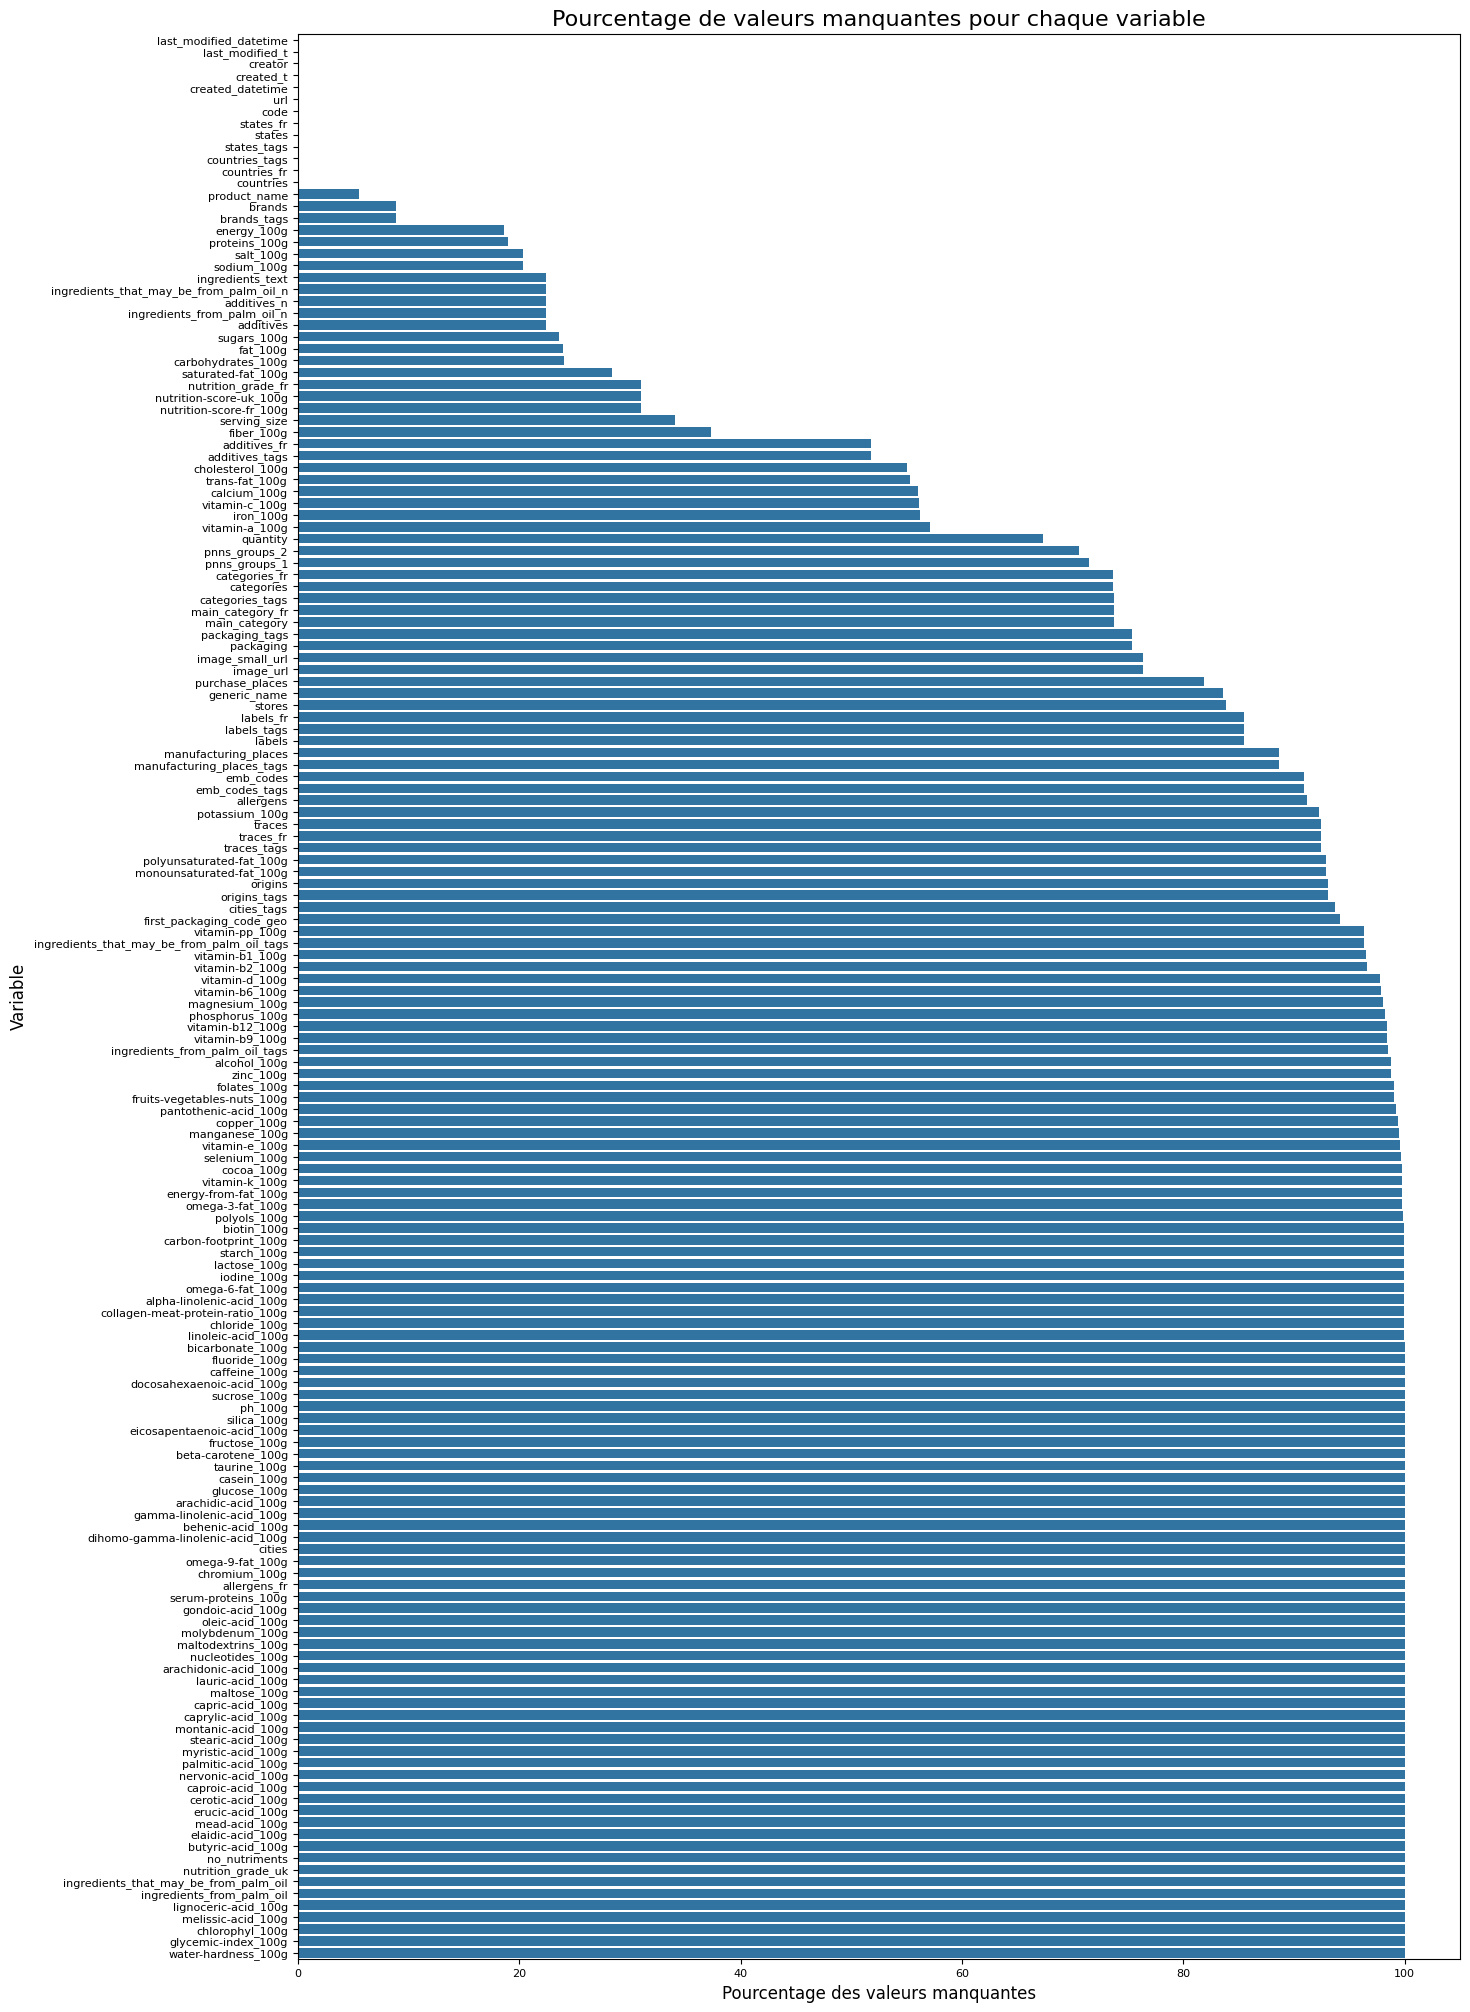

In [47]:
proportion_of_emptiness = df.isnull().mean() * 100
proportion_of_emptiness = pd.DataFrame(proportion_of_emptiness).reset_index().sort_values(0)

fig = plt.figure(figsize=(15, 25))

plt.rcParams.update({"font.size": 8})
sns.barplot(data=proportion_of_emptiness, x=0, y="index")
plt.xlabel("Pourcentage des valeurs manquantes", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.title("Pourcentage de valeurs manquantes pour chaque variable", fontsize=16)
plt.show()

Supprimons les variables comportants moins de 50% de taux de remplissage.

In [48]:
df = df.loc[:, missing_values < 0.5]

Utilisons l'URL des produits pour supprimer les doublons.

In [49]:
duplicated_rows = df["url"].duplicated()
duplicated_rows.sum()

np.int64(22)

In [50]:
df = df.loc[duplicated_rows == False]
df.duplicated().sum()

np.int64(0)

Nous allons maintenant faire la sélection des variables qui seront destinées à prédire la variable cible. Pour cela, nous choisissons des variables étant remplies au minimum à 50%. Il faut, bien sûr, aussi qu'elles aient un rapport avec notre variable cible afin qu'elles puissent la prédire.

In [51]:
df = df[[
    "url",
    "nutrition_grade_fr",
    "energy_100g",
    "fat_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g"
]]

In [52]:
def features_selection(dataframe):
    dataframe.columns
    target = dataframe["calcium_100g"]
    df.isnull().mean()
    dataframe = dataframe.loc[df["code"].duplicated() == False]
    dataframe = dataframe[[
        "nutrition_grade_fr",
        "energy_100g",
        "fat_100g",
        "sugars_100g",
        "fiber_100g",
        "proteins_100g",
        "salt_100g"
    ]]
    return (dataframe, target)

## Étape 2 : Identifiez et traitez les valeurs aberrantes

Occupons-nous maintenant de traiter les valeurs aberrantes. Pour cela, nous allons en premier lieu utiliser des boîtes à moustaches afin de visualiser la distribution des valeurs nutritives.

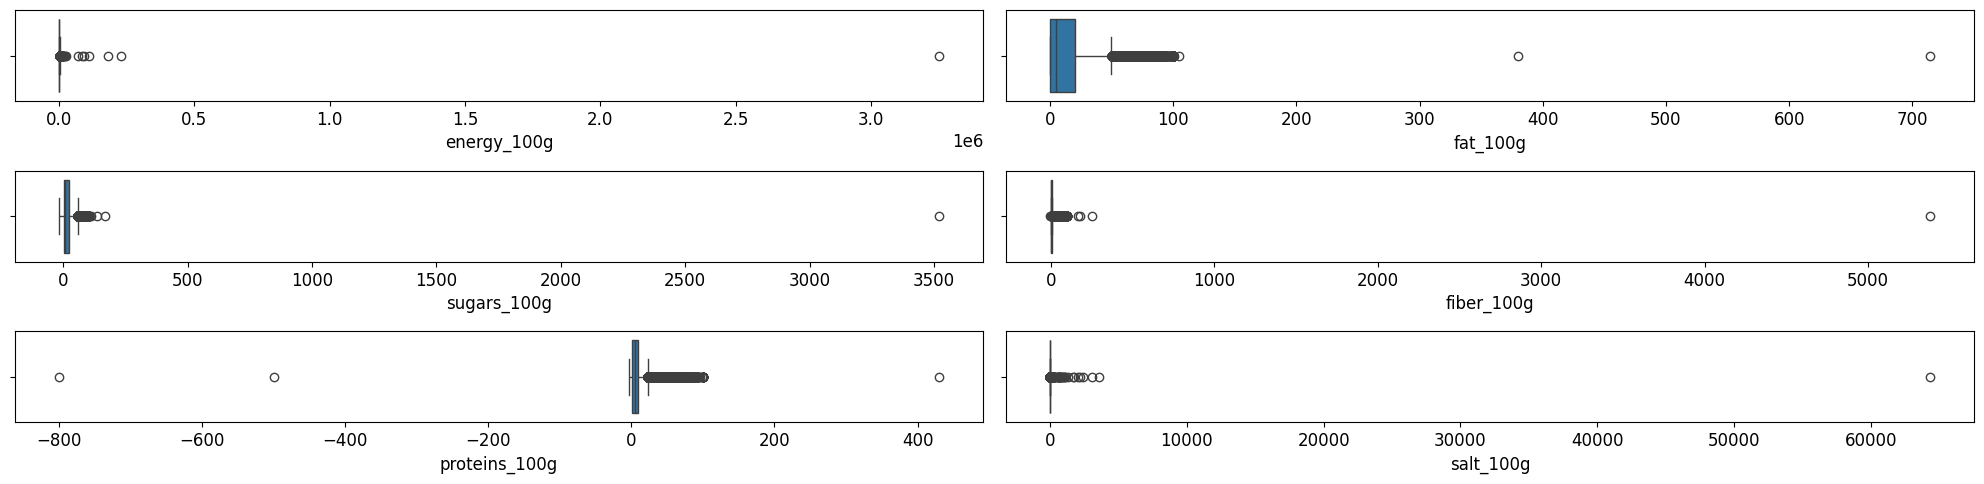

In [53]:
nutritive_values = ["energy_100g", "fat_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g"]

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(3, 2, figsize=(20,5))

ax = ax.flatten()
for i, value in enumerate(nutritive_values[0:len(nutritive_values)]):
    sns.boxplot(data=df, x=value, ax=ax[i])

plt.tight_layout()

On repère deux problèmes. Premièrement, certaines valeurs sont négatives, ce qui, vous en conviendrez, est impossible. Deuxièmement, des valeurs dépassent la valeur maximum possible pour ce type de données. Par exemple, le produit le plus gras contient plus de 700g de gras pour 100g de produit. C'est bien évidemment impossible. Nous allons donc supprimer les valeurs en trop, et nous allons même rechercher les aliments contenant le plus de protéines et de fibres possible, ainsi que l'aliment apportant le plus de kilos joules au corps, afin d'estimer des valeurs maximum plus précises pour ces données.

In [54]:
df = df.loc[((df["energy_100g"] >= 0) & (df["energy_100g"] < 3700)) | (df["energy_100g"].isna())]
df = df.loc[((df["fat_100g"] >= 0) & (df["fat_100g"] < 100)) | (df["fat_100g"].isna())]
df = df.loc[((df["sugars_100g"] >= 0) & (df["sugars_100g"] < 100)) | (df["sugars_100g"].isna())]
df = df.loc[((df["fiber_100g"] >= 0) & (df["fiber_100g"] < 16)) | (df["fiber_100g"].isna())]
df = df.loc[((df["proteins_100g"] >= 0) & (df["proteins_100g"] < 58)) | (df["proteins_100g"].isna())]
df = df.loc[((df["salt_100g"] >= 0) & (df["salt_100g"] < 100)) | (df["salt_100g"].isna())]
df.isna().mean()

url                   0.000003
nutrition_grade_fr    0.310935
energy_100g           0.189722
fat_100g              0.242752
sugars_100g           0.237809
fiber_100g            0.375806
proteins_100g         0.193303
salt_100g             0.207014
dtype: float64

(314181, 8)


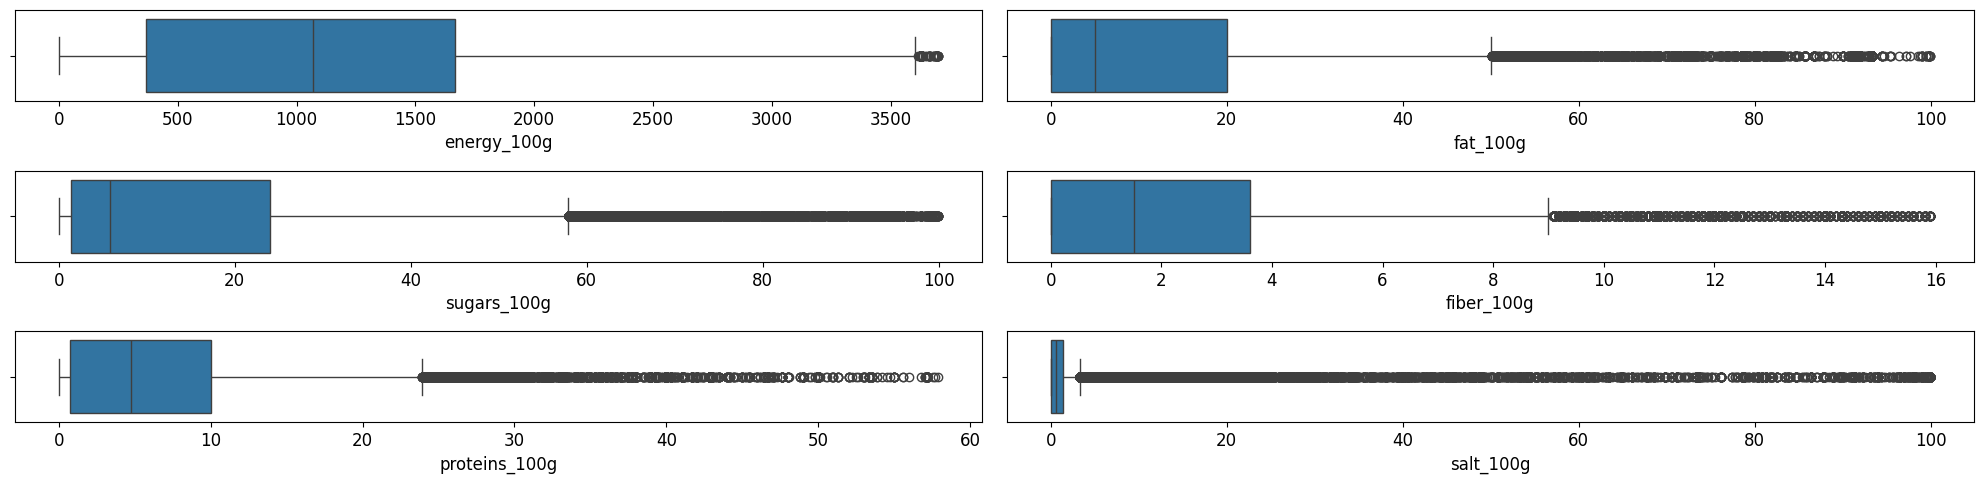

In [55]:
fig, ax = plt.subplots(3, 2, figsize=(20,5))
ax = ax.flatten()

for i, value in enumerate(nutritive_values[0:len(nutritive_values)]):
    sns.boxplot(data=df, x=value, ax=ax[i])

plt.tight_layout()
print(df.shape)

Nous allons aussi analyser le nutriscore des produits. En premier lieu, vérifions que les seules valeurs présentes sont a, b, c, d, e. Ensuite, mettons en place un histogramme pour en apprendre davantage sur la distribution de ces valeurs.

In [56]:
df["nutrition_grade_fr"].unique()

array([nan, 'd', 'b', 'c', 'a', 'e'], dtype=object)

<Axes: xlabel='nutrition_grade_fr', ylabel='Count'>

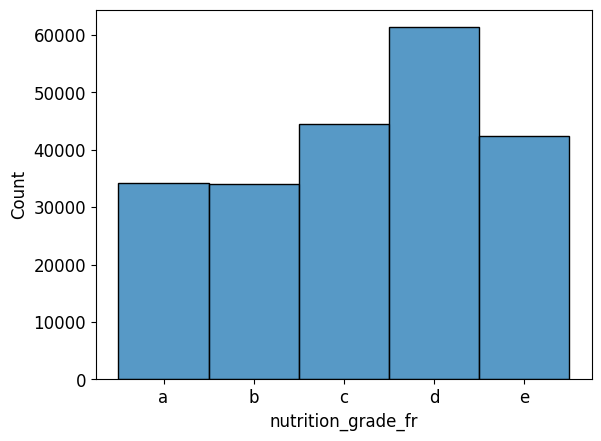

In [57]:
df['nutrition_grade_fr'] = pd.Categorical(df['nutrition_grade_fr'], ["a","b","c","d","e"])
sns.histplot(data=df["nutrition_grade_fr"])

## Étape 3 : Identifiez et traitez les valeurs manquantes

Nous allons maintenant tenter de remplir les valeurs manquantes de notre DataFrame. Pour ceci, nous allons d'abord analyser la corrélation entre nos variables.

In [58]:
nutrition_grade_encoder = LabelEncoder()
df.loc[:, "nutrition_grade_fr"] = nutrition_grade_encoder.fit_transform(df["nutrition_grade_fr"])
nutritive_values.append("nutrition_grade_fr")

print(df.shape)
print(df.isna().mean())

(314181, 8)
url                   0.000003
nutrition_grade_fr    0.000000
energy_100g           0.189722
fat_100g              0.242752
sugars_100g           0.237809
fiber_100g            0.375806
proteins_100g         0.193303
salt_100g             0.207014
dtype: float64


/tmp/ipykernel_2474/1264365103.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5 3 1 ... 5 5 5]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, "nutrition_grade_fr"] = nutrition_grade_encoder.fit_transform(df["nutrition_grade_fr"])


Nos données sont plutôt corréllées entre elle excepté pour la variable "salt_100g". Nous allons donc utilisé l'iterative imputer pour remplir nos données manquante, excepté pour le sel, où nous nous contenterons de les supprimer.

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Step 1: Generate Synthetic Dataset with Missing Values
np.random.seed(1)
n_samples = 1000
n_features = 5
X = df[["energy_100g", "sugars_100g"]]
y = df["fat_100g"]

# Step 2: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputation Method:
# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train logistic regression model
model_imputed = LogisticRegression()
model_imputed.fit(X_train_imputed, y_train)

# Evaluate model on test set
accuracy_imputed = model_imputed.score(X_test_imputed, y_test)
print("Accuracy with Imputation Method:", accuracy_imputed)

ValueError: Input y contains NaN.

Nous allons regarder les valeurs maximales de nos données, afin de vérifier que les valeurs imputer ne sortent pas des valeurs métier que nous avons établis.

In [20]:
df.describe()

,nutrition_grade_fr,energy_100g,fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,314181.000000,314181.000000,314181.000000,314181.000000,314181.000000,314181.000000,314181.000000
mean,3.072458,1229.197510,10.696762,25.077963,1.829635,6.013028,2.732344
std,1.710913,751.842751,15.076839,25.749616,2.667579,7.205112,9.437229
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,482.000000,0.600000,2.220000,0.000000,1.600000,0.111760
50%,3.000000,1406.000000,3.750000,12.000000,0.700000,3.030000,0.911860
75%,5.000000,1795.000000,15.940000,59.000000,2.500000,8.200000,3.017520
max,5.000000,3699.000000,99.900000,99.950000,15.900000,57.900000,99.930000


## Étape 4 : Effectuez les analyses uni-variée et bi-variée

Maintenant que nous nous sommes occupés des valeurs abberantes et manquantes, tentons de comprendre en profondeur nos valeurs restantes, ainsi que leurs distribution. Commençons par regarder nos valeus numériques.

In [21]:
df.describe()

,nutrition_grade_fr,energy_100g,fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,314181.000000,314181.000000,314181.000000,314181.000000,314181.000000,314181.000000,314181.000000
mean,3.072458,1229.197510,10.696762,25.077963,1.829635,6.013028,2.732344
std,1.710913,751.842751,15.076839,25.749616,2.667579,7.205112,9.437229
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,482.000000,0.600000,2.220000,0.000000,1.600000,0.111760
50%,3.000000,1406.000000,3.750000,12.000000,0.700000,3.030000,0.911860
75%,5.000000,1795.000000,15.940000,59.000000,2.500000,8.200000,3.017520
max,5.000000,3699.000000,99.900000,99.950000,15.900000,57.900000,99.930000


Ensuite, regardons la distribution de ces même valeurs. Nous allons en premier lieu les faire passer pars un "scaler" afin qu'elle est des valeurs minimum et maximum comparable, ce qui facilitera l'analyse de leur distribution.

In [22]:
scaler = StandardScaler()
nutritive_values.append("salt_100g")
nutritive_values.remove("nutrition_grade_fr")
scaled_df = df
scaled_df[nutritive_values] = scaler.fit_transform(df[nutritive_values])
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

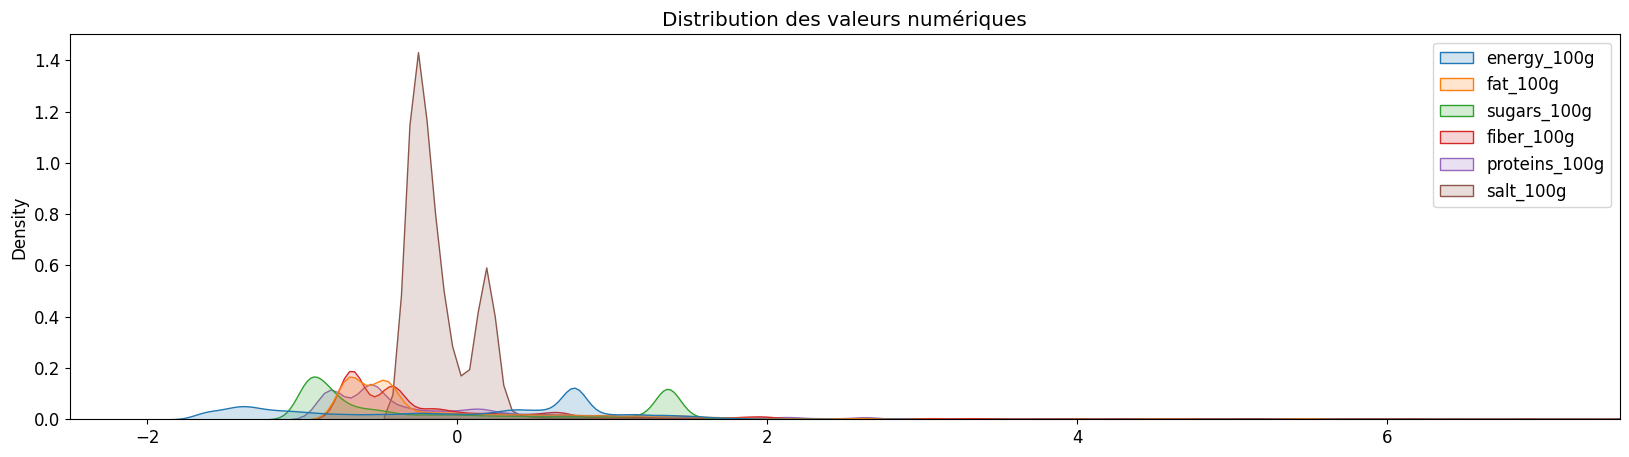

In [23]:
fig, ax = plt.subplots(figsize=(20,5))
sns.kdeplot(data=scaled_df[nutritive_values], fill=True, alpha=.2)
ax.set_title("Distribution des valeurs numériques")
ax.set_xlim(-2.5, 7.5)
plt.show()

Regardons maintenant la distribution des nutriscores à l'aide d'un histogramme.

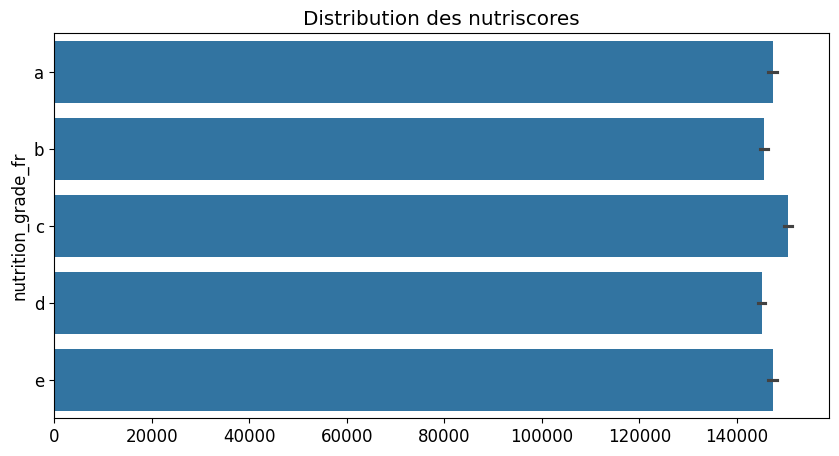

In [24]:
df["nutrition_grade_fr"] = nutrition_grade_encoder.inverse_transform(df["nutrition_grade_fr"].astype(int))
df['nutrition_grade_fr'] = pd.Categorical(df['nutrition_grade_fr'], ["a","b","c","d","e"])

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=df["nutrition_grade_fr"])
ax.set_title("Distribution des nutriscores")
plt.show()

Pour finir avec cette étape, nous allons regarder la corrélation de nos variables.

In [25]:
correlation_table = scaled_df
correlation_table = pd.merge(correlation_table, pd.DataFrame(target), how="right", left_on="url", right_on="url")
correlation_table.dropna(inplace=True)
target_encoder = LabelEncoder()
nutrition_grade_encoder = LabelEncoder()
correlation_table.loc[:, "main_category_fr"] = target_encoder.fit_transform(correlation_table["main_category_fr"])
correlation_table.loc[:, "nutrition_grade_fr"] = nutrition_grade_encoder.fit_transform(correlation_table["nutrition_grade_fr"])

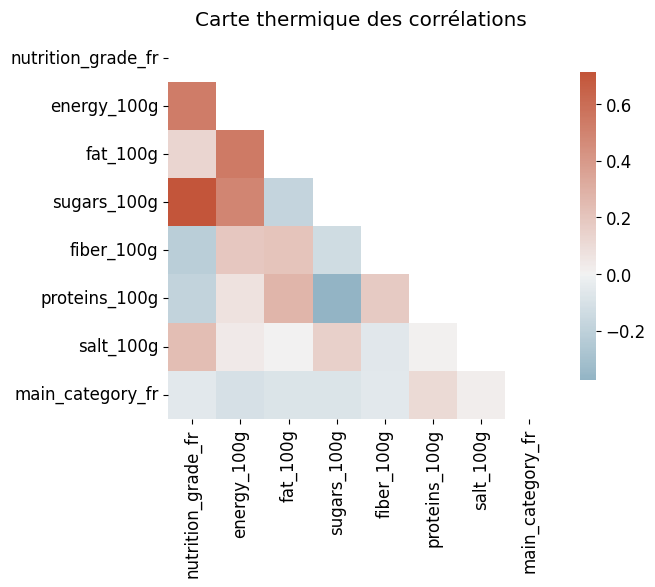

In [26]:
corr_matrix = correlation_table.drop(columns=["url"]).corr()

f, ax = plt.subplots(figsize=(7, 5))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, square=True, cbar_kws={"shrink": .8})
ax.set_title("Carte thermique des corrélations")
plt.show()

## Étape 5 : Réalisez une analyse multi-variée

In [27]:
from sklearn.decomposition import PCA

pca_scaler = StandardScaler()
pca_table = pca_scaler.fit_transform(correlation_table.drop(columns=["url"]))
pca_table = pd.DataFrame(pca_table)
pca_table.describe().round(2)

,0,1,2,3,4,5,6,7
count,83194.00,83194.00,83194.00,83194.00,83194.00,83194.00,83194.00,83194.00
mean,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.76,-1.69,-0.73,-0.99,-0.72,-0.91,-0.28,-1.39
25%,-0.61,-1.00,-0.60,-0.92,-0.64,-0.61,-0.27,-0.80
50%,-0.03,0.29,-0.48,-0.54,-0.43,-0.43,-0.20,-0.15
75%,1.12,0.75,0.30,1.29,0.20,0.31,0.09,0.64
max,1.12,3.33,6.12,2.82,5.95,7.50,7.86,4.71


In [28]:
n_components = 6

pca = PCA(n_components=n_components)

pca.fit(pca_table)

pca.explained_variance_ratio_

array([0.29214877, 0.22277989, 0.13676074, 0.11583346, 0.10443104,
       0.07674392])

In [29]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()

x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6]

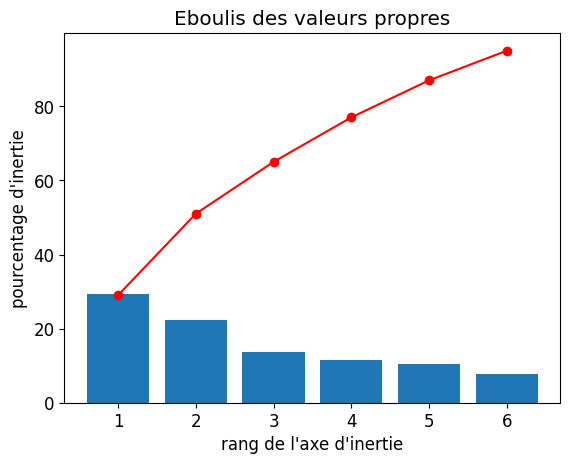

In [30]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [31]:
features = correlation_table.drop(columns=["url"]).columns
pcs = pd.DataFrame(pca.components_)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,nutrition_grade_fr,energy_100g,fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,main_category_fr
F1,0.58,0.48,0.12,0.57,-0.10,-0.21,0.18,-0.12
F2,-0.04,0.43,0.62,-0.21,0.43,0.45,-0.06,-0.07
F3,0.14,-0.04,0.05,-0.07,-0.26,0.39,0.55,0.67
F4,-0.07,-0.17,-0.00,-0.12,0.07,0.05,0.74,-0.62
F5,-0.11,0.03,-0.32,0.22,0.81,-0.19,0.22,0.31
F6,0.13,0.00,-0.52,0.27,0.04,0.74,-0.19,-0.22


<Axes: >

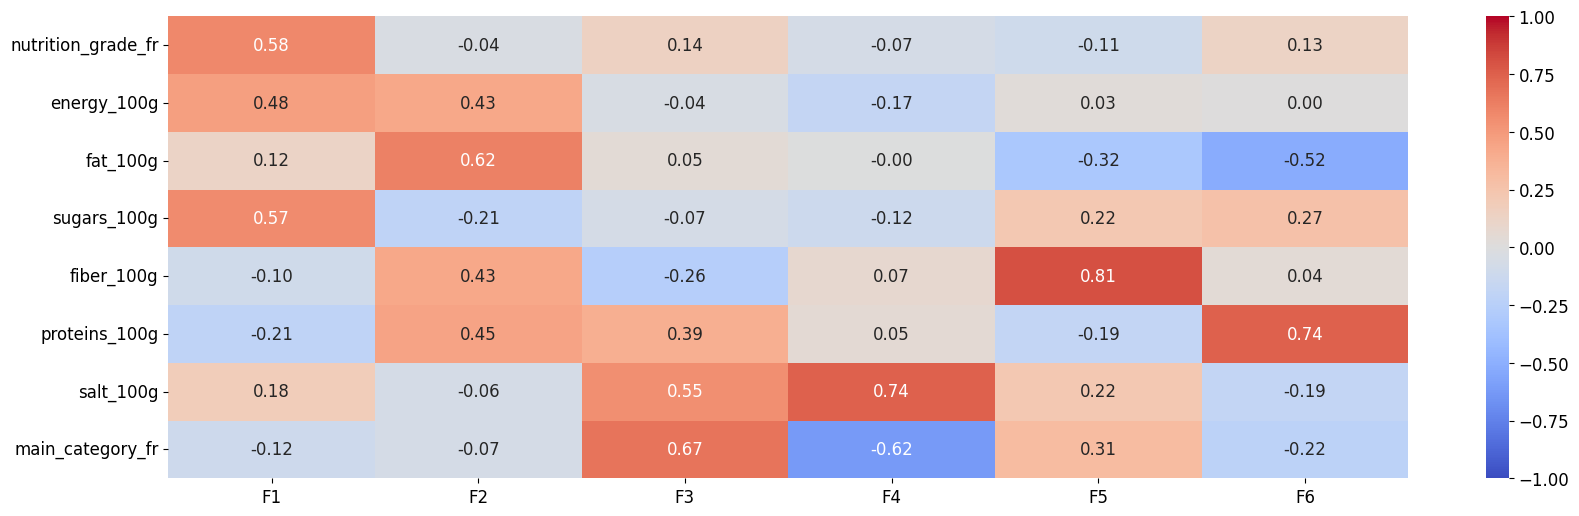

In [32]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [33]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

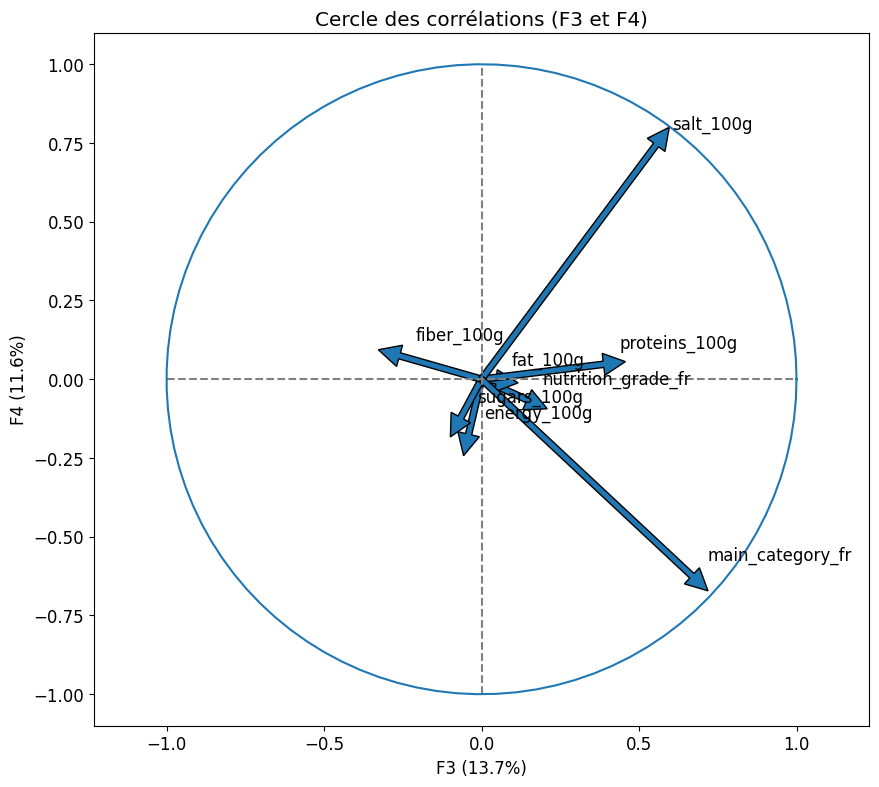

In [37]:
correlation_graph(pca, (2, 3), features)

In [40]:
pca_table.columns = features
pca_table
f_oneway(pca_table["main_category_fr"], pca_table["salt_100g"])

F_onewayResult(statistic=np.float64(4.054499466608688e-29), pvalue=np.float64(1.0))